In [4]:
import sagemaker
import boto3
import pandas as pd


In [5]:

from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = 'arn:aws:iam::534860077983:role/sagemaker_notebook_role'
print(role)

arn:aws:iam::534860077983:role/sagemaker_notebook_role


In [6]:

bucket='sagemaker12'
data_key = 'forecast/Building_Dummy_New_car&parts_sales_by_model.xlsx'
data_location = 's3://{}/{}'.format(bucket, data_key)
df=pd.read_excel(data_location)


In [7]:
df['Date']=pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

In [8]:
df.head()

,Year,Month,Make,Model,Door_Handles_Sold,Tires_Sold,Brake_Hydraulic_Hose_Sold,Air_Suspension_Sold,Window_Regulators_Sold,Date
0,2007,1,Volkswagen,Volkswagen Passat,1267,276,392,547,187,2007-01-01
1,2007,2,Volkswagen,Volkswagen Passat,602,258,326,333,118,2007-02-01
2,2007,3,Volkswagen,Volkswagen Passat,521,268,338,544,177,2007-03-01
3,2007,3,Toyota,Toyota Avensis,521,259,321,767,149,2007-03-01
4,2007,3,Volkswagen,Volkswagen Golf,402,226,247,343,644,2007-03-01


In [85]:
dd=df.groupby(['Date'])['Door_Handles_Sold'].sum().reset_index()

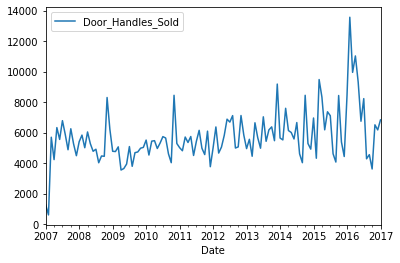

In [79]:
dd.plot()

In [10]:
dd.set_index(dd['Date'], inplace=True) 

In [11]:
dd=dd.drop(['Date'],axis=1)

In [86]:
test1= dd.iloc[109:]  

In [60]:
train = dd.iloc[:109]
test= dd.iloc[109:]  

In [61]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_sc= scaler.fit_transform(train)

In [70]:
scaler = MinMaxScaler(feature_range=(0, 1))
test_sc= scaler.fit_transform(test)

In [71]:
test_d=np.array(test_sc)

In [72]:
te=np.reshape(test_d, (test_d.shape[0], 1, test_d.shape[1]))

In [62]:
tr_size = int(len(train_sc) * 0.60)
tst_size = len(train_sc) - tr_size
tr, tst = ds[0:tr_size,:], ds[tr_size:len(ds),:]

In [63]:
def prepare_data(dataset, look_back=1):
    dX, dY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dX.append(a)
        dY.append(dataset[i + look_back, 0])
    return np.array(dX), np.array(dY)

In [64]:
look_back = 1
trX, trY = prepare_data(tr, look_back)
tstX, tstY = prepare_data(tst, look_back)
# reshape input to be [samples, time steps, features]
trX = np.reshape(trX, (trX.shape[0], 1, trX.shape[1]))
tstX = np.reshape(tstX, (tstX.shape[0], 1, tstX.shape[1]))

In [66]:
#import tensorflow 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.metrics import mean_squared_error

In [67]:
model = Sequential()

model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [68]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [78]:
fcst=model.fit(trX, trY,validation_data=(tstX, tstY),epochs=100, batch_size=1, verbose=2)

Train on 63 samples, validate on 54 samples
Epoch 1/100
 - 0s - loss: 0.0066 - val_loss: 0.0261
Epoch 2/100
 - 0s - loss: 0.0067 - val_loss: 0.0258
Epoch 3/100
 - 0s - loss: 0.0067 - val_loss: 0.0264
Epoch 4/100
 - 0s - loss: 0.0067 - val_loss: 0.0262
Epoch 5/100
 - 0s - loss: 0.0068 - val_loss: 0.0253
Epoch 6/100
 - 0s - loss: 0.0067 - val_loss: 0.0266
Epoch 7/100
 - 0s - loss: 0.0067 - val_loss: 0.0263
Epoch 8/100
 - 0s - loss: 0.0067 - val_loss: 0.0272
Epoch 9/100
 - 0s - loss: 0.0067 - val_loss: 0.0266
Epoch 10/100
 - 0s - loss: 0.0067 - val_loss: 0.0270
Epoch 11/100
 - 0s - loss: 0.0067 - val_loss: 0.0260
Epoch 12/100
 - 0s - loss: 0.0068 - val_loss: 0.0259
Epoch 13/100
 - 0s - loss: 0.0067 - val_loss: 0.0262
Epoch 14/100
 - 0s - loss: 0.0067 - val_loss: 0.0270
Epoch 15/100
 - 0s - loss: 0.0067 - val_loss: 0.0273
Epoch 16/100
 - 0s - loss: 0.0066 - val_loss: 0.0256
Epoch 17/100
 - 0s - loss: 0.0067 - val_loss: 0.0267
Epoch 18/100
 - 0s - loss: 0.0066 - val_loss: 0.0256
Epoch 19/10

In [73]:
pred=model.predict(te)

In [75]:
p=scaler.inverse_transform(pred)

In [82]:
p

array([[8469.432 ],
       [7751.002 ],
       [7972.7427],
       [7618.116 ],
       [7060.5728],
       [7385.2925],
       [6507.617 ],
       [6569.2495],
       [6355.883 ],
       [7008.477 ],
       [6934.1606],
       [7079.816 ]], dtype=float32)

In [97]:
p[:, 0]

array([8469.432 , 7751.002 , 7972.7427, 7618.116 , 7060.5728, 7385.2925,
       6507.617 , 6569.2495, 6355.883 , 7008.477 , 6934.1606, 7079.816 ],
      dtype=float32)

In [100]:
data=pd.DataFrame({'Actual_values':test['Door_Handles_Sold'],'Prediction_values':np.round(p[:, 0])})

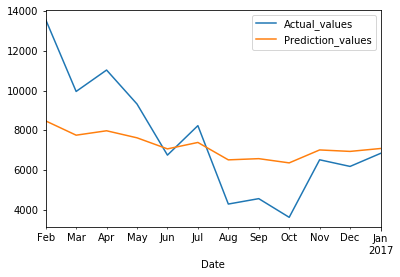

In [102]:
data.plot()